In [1]:
import numpy as np
import napari
from skimage import filters, measure
from tqdm import tqdm
import pandas as pd

from sklearn import preprocessing
import h5py
import warnings
import matplotlib.pyplot as plt


# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning, module="skimage.measure._regionprops")
warnings.filterwarnings("ignore", category=RuntimeWarning)

def circular_filter(array_shape, pixel_radius):
    filter = np.zeros(array_shape)
    N = array_shape[0]
    x, y = np.arange(N), np.arange(N)
    X, Y = np.meshgrid(x, y)
    filter[(X-N//2)**2 + (Y-N//2)**2 < pixel_radius**2] = 1
    return filter

def fourier_filter_with_thresholding(image, threshold, filter):

    temp = np.zeros(image.shape)
    temp = temp + image
    temp[image<threshold] = 0
    ###############################
    temp = filters.gaussian(temp)

    a_fourier = np.fft.fftshift(np.fft.fft2(temp))
    H, W = a_fourier.shape
    a_fourier[H//2:H//2 + 1, W//2:W//2 + 1]=0
    a_fourier = a_fourier * filter
    a_mod = np.fft.ifft2(a_fourier)
    ################################
    return np.abs(a_mod)

In [4]:
apop_dir = "C:/rkka_Projects/Cell/Data/Apoptosis/"
# necro_dir = "C:/rkka_Projects/Cell/Data/Necrosis/"
necropto_dir = "C:/rkka_Projects/Cell/Data/Necroptosis/"

apop_file_list = ['sam_manual_mlp_boxed_compressed_230512.160429.CD95_TNF_Ctr.003.CD95.A1.T001P12.TCF.h5',
                'sam_manual_mlp_boxed_compressed_230512.160429.CD95_TNF_Ctr.003.CD95.A1.T001P15.TCF.h5',
                'sam_manual_mlp_boxed_compressed_230512.160429.CD95_TNF_Ctr.003.CD95.A1.T001P19.TCF.h5',
                'sam_manual_mlp_boxed_compressed_230512.160429.CD95_TNF_Ctr.003.CD95.A1.T001P20.TCF.h5',
                'sam_manual_mlp_boxed_compressed_230512.160429.CD95_TNF_Ctr.003.CD95.A1.T001P26.TCF.h5',
                'sam_manual_mlp_boxed_compressed_230512.160429.CD95_TNF_Ctr.003.CD95.A1.T001P28.TCF.h5',
                'sam_manual_mlp_boxed_compressed_230512.160429.CD95_TNF_Ctr.003.CD95.A1.T001P29.TCF.h5',
                'sam_manual_mlp_boxed_compressed_230512.160429.CD95_TNF_Ctr.003.CD95.A1.T001P34.TCF.h5',
                'sam_manual_mlp_boxed_compressed_230512.160429.CD95_TNF_Ctr.003.CD95.A1.T001P35.TCF.h5'
            ]

"""
necro_file_list = ['timelapsed_mlp_boxed_230721.132040.Necrosis_NaOH.001.Group1.A1.T001P01.TCF.h5',
                'timelapsed_mlp_boxed_230725.092931.HeLa_NaOH.002.Group1.A1.T002P01.TCF.h5',
                'timelapsed_mlp_boxed_230725.094439.HeLa_NaOH.002.Group1.A1.T002P01.TCF.h5',
                'timelapsed_mlp_boxed_230725.095615.HeLa_NaOH.003.Group1.A1.T003P01.TCF.h5',
                'timelapsed_mlp_boxed_230725.100700.HeLa_NaOH.004.Group1.A1.T004P01.TCF.h5',
                'timelapsed_mlp_boxed_230725.102033.HeLa_NaOH.005.Group1.A1.T005P01.TCF.h5',
            ]
"""

necropto_file_list = ['sam_manual_mlp_boxed_compressed_230510.174730.HeLa_Hoechst.001.Group1.A2.T001P02.TCF.h5',
             'sam_manual_mlp_boxed_compressed_230510.174730.HeLa_Hoechst.001.Group1.A2.T001P03.TCF.h5',
             'sam_manual_mlp_boxed_compressed_230510.174730.HeLa_Hoechst.001.Group1.A2.T001P17.TCF.h5',
             'sam_manual_mlp_boxed_compressed_230510.174730.HeLa_Hoechst.001.Group2.A1.T001P02.TCF.h5',
             'sam_manual_mlp_boxed_compressed_230510.174730.HeLa_Hoechst.001.Group2.A1.T001P10.TCF.h5',
             'sam_manual_mlp_boxed_compressed_230510.174730.HeLa_Hoechst.001.Group2.A1.T001P19.TCF.h5',
             'sam_manual_mlp_boxed_compressed_230510.174730.HeLa_Hoechst.001.Group2.A1.T001P20.TCF.h5'
            ]

mode_list = ['manual_sam_not_rescaled_Apoptosis_with_bshape', 'manual_sam_not_rescaled_Necroptosis_with_bshape']
dir_list = [apop_dir, necropto_dir]
file_list_list = [apop_file_list, necropto_file_list]

time_list = [str(i*0.5).zfill(4) for i in range(36)]

In [2]:
necropto_dir = "C:/rkka_Projects/Cell/Data/Necroptosis/"

necropto_file_list = ['sam_manual_mlp_boxed_compressed_230510.174730.HeLa_Hoechst.001.Group1.A2.T001P03.TCF.h5'
            ]

mode_list = ['manual_sam_not_rescaled_Necroptosis_with_bshape']
dir_list = [necropto_dir]
file_list_list = [necropto_file_list]

time_list = [str(i*0.5).zfill(4) for i in range(36)]

<h1> 병렬처리 코드 </h1>

<h3> (1) box가 애초에 크기 리스케일링 안하고 된거라서, 그 volume 자체가 물리적으로 유의미한 값이기는 함. </h3>
<h3> 다만 문제는 box간에 크기를 맞춰주지 않은것인데, 이부분은 으음.. 실험마다 세포크기가 다르다는게 문제임 </h3>

In [5]:
import h5py
import numpy as np
import pandas as pd
from skimage import filters, measure, morphology
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
import logging

logging.basicConfig(level=logging.INFO)  # Configure logging level as needed

def process_time(box, time, file, box_idx):

    # Above 1.327에 대해서만 분석
    
    box_for_labeling = box.copy()
    try:
        thr = filters.threshold_multiotsu(box_for_labeling, 4)

        box_for_labeling[box_for_labeling<1.327] = 0
        temp_bin = box_for_labeling.copy().astype(bool)
        temp_bin = morphology.remove_small_objects(temp_bin, 500)
        temp_bin = morphology.remove_small_holes(temp_bin, 500)
        temp_int = temp_bin.astype(int)
        
    except Exception as e:
        # when otsu fails:
        logging.error(f"Otsu fail for box : {box_idx}, time : {time} -- file : {file}: {e}. Applied RI threshold 1.31")
        box_for_labeling[box_for_labeling<1.31] = 0
        temp_bin = box_for_labeling.copy().astype(bool)
        temp_bin = morphology.remove_small_objects(temp_bin, 500)
        temp_bin = morphology.remove_small_holes(temp_bin, 500)
        temp_int = temp_bin.astype(int)
        
    properties = ['area', 'area_convex','axis_major_length', 'euler_number', 'extent',
                            'solidity', 'inertia_tensor_eigvals'] 
    cell_props = measure.regionprops_table(temp_int, properties=properties)
    cell_props = pd.DataFrame(cell_props)
    cell_props = cell_props[cell_props['area'] >= 100]
    cell_props = cell_props.replace([-np.inf, np.inf], 0)
        
    box_props = pd.DataFrame()

    # box shape
    box_props['box_shape'] = [box.shape]
    # find mean_RI
    box_props['mean_RI'] = np.mean(box[temp_bin!=0])
    # high RI : over 1.35
    temp = box.copy()
    temp[temp<1.35]=0
    box_props['ri_above_1.35_volume'] = len(temp[temp!=0])
    
    for cell_prop in list(cell_props.columns):
        if cell_prop=='area':
            box_props['volume'] = cell_props[cell_prop]
        elif cell_prop=='area_convex':
            box_props['volume_convex'] = cell_props[cell_prop]
        else:
            box_props[cell_prop] = cell_props[cell_prop]
    

    for prop in list(box_props.columns):
        box_props = box_props.rename(columns={prop: time + 'h_' + prop})
            
    box_props = box_props.reset_index(drop=True)
            
    return box_props


def process_box(a, box_idx, time_list, file):
    
    box_df = pd.DataFrame()
    cell_props_list = []
    
    for time in time_list:
        box = np.array(a['box/' + str(box_idx).zfill(3) + '/time/' + str(time)])
        # RI : 1.3~1.4 rescaling
        # box = 1.3 + 0.1*(box-box.min())/(box.max()-box.min())
        
        cell_props = process_time(box, time, file, box_idx)
        cell_props_list.append(cell_props)
    
    box_df = pd.concat(cell_props_list, axis=1)
    
    print('a box processed')
    
    return box_df

def process_file(file, dir, time_list):
    try:
        a = h5py.File(dir + file)
        file_df = pd.DataFrame()
        futures = []
        
        with ThreadPoolExecutor() as executor:
            for box_idx in range(len(a['box'])):
                futures.append(executor.submit(process_box, a, box_idx, time_list, file))
            
            for future in futures:
                box_df = future.result()
                if not box_df.empty:
                    file_df = pd.concat([file_df, box_df], axis=0)
                    
        print('################')
        print('a file processed')
        print('################')
        return file_df
    
    except Exception as e:
        logging.error(f"Error processing file {file}: {e}")
        return pd.DataFrame()

for dir_idx, dir in tqdm(enumerate(dir_list), desc='Cell Death Iters'):
    mode = mode_list[dir_idx]
    file_list = file_list_list[dir_idx]
    cell_death_df = pd.DataFrame()
    futures = []
    
    with ThreadPoolExecutor() as executor:
        for file in file_list:
            futures.append(executor.submit(process_file, file, dir, time_list))
        
        for future in futures:
            try:
                file_df = future.result()
                if not file_df.empty:
                    cell_death_df = pd.concat([cell_death_df, file_df], axis=0)
            except Exception as e:
                logging.error(f"Error processing file: {e}")
    
    cell_death_df.to_csv(mode + '.csv', index=False)


Cell Death Iters: 0it [00:00, ?it/s]

a box processed
a box processed
a box processed
a box processed
a box processed
a box processed
a box processed
a box processed
a box processed
a box processed
a box processed
a box processed
a box processed
a box processed
a box processed
a box processed
a box processed
a box processed
a box processed
a box processed
a box processed
a box processed
a box processed
a box processed
a box processed
a box processed
a box processed
a box processed
a box processed
a box processed
a box processed
a box processed
a box processed
a box processed
a box processed
################
a file processed
################
a box processed
a box processed
a box processed
a box processed
a box processeda box processed

################
a file processed
################
a box processed
a box processed
a box processed
a box processed
a box processed
a box processed
################
a file processed
################
a box processed
a box processed
a box processed
a box processed
a box processed
a box processed

Cell Death Iters: 1it [21:44, 1304.09s/it]

a box processed
################
a file processed
################
a box processed
a box processed
a box processed
a box processed
a box processed
a box processed
a box processed
a box processed
a box processed
a box processed
a box processed
a box processed
a box processed
a box processed
a box processed
a box processed
a box processed
a box processed
a box processed
a box processed
a box processed
a box processed
a box processed
a box processed
a box processed
a box processed
a box processed
a box processed
a box processed
a box processed
a box processed
a box processed
a box processed
a box processed
a box processed
a box processed
a box processed
a box processed
a box processed
a box processed
a box processed
a box processed
################
a file processed
################
a box processed
a box processed
################
a file processed
################
a box processed
a box processed
a box processed
a box processed
a box processed
a box processed
################
a file process

Cell Death Iters: 2it [52:30, 1575.12s/it]

a box processed
################
a file processed
################


<h1> 원래 코드 </h1>

In [4]:
import napari
viewer = napari.Viewer()

In [5]:
import h5py
import numpy as np
a = h5py.File(r"C:\rkka_Projects\Cell\Data\Necroptosis\sam_manual_mlp_boxed_compressed_230510.174730.HeLa_Hoechst.001.Group1.A2.T001P03.TCF.h5")
box = np.array(a['box/003/time/10.0'])

In [6]:
viewer.add_image(box)

<Image layer 'box' at 0x1cfbb85ef40>

In [7]:
import pandas as pd
from skimage import morphology, filters, measure

In [8]:
temp = box.copy()
thr = filters.threshold_multiotsu(temp, 4)

temp[temp<1.33] = 0
temp_bin = temp.copy().astype(bool)
temp_bin = morphology.remove_small_objects(temp_bin, 500)
temp_bin = morphology.remove_small_holes(temp_bin, 500)
viewer.add_image(temp_bin)

<Image layer 'temp_bin' at 0x1cff7cf0910>

In [10]:
properties = ['area', 'area_convex','axis_major_length', 'euler_number', 'extent',
                        'solidity', 'inertia_tensor_eigvals'] 

props = measure.regionprops_table(temp_bin.astype(int), properties=properties)
props = pd.DataFrame(props)

temp = box.copy()
temp[temp<1.35]=0
props['ri_above_1.35_volume'] = len(temp[temp!=0])
props['mean_ri'] = np.mean(box[temp_bin!=0])

props

,area,area_convex,axis_major_length,euler_number,extent,solidity,inertia_tensor_eigvals-0,inertia_tensor_eigvals-1,inertia_tensor_eigvals-2,ri_above_1.35_volume,mean_ri
0,15769.0,87112.0,129.928106,-159,0.091414,0.18102,1536.543463,847.311302,695.723501,845,1.336069


In [76]:
properties = ['area', 'area_convex','axis_major_length', 'euler_number', 'extent',
                        'solidity', 'inertia_tensor_eigvals'] 

props = measure.regionprops_table(temp_bin.astype(int), properties=properties)
props = pd.DataFrame(props)

temp = box.copy()
temp[temp<1.35]=0
props['ri_above_1.35_volume'] = len(temp[temp!=0])

props

,area,area_convex,axis_major_length,euler_number,extent,solidity,inertia_tensor_eigvals-0,inertia_tensor_eigvals-1,inertia_tensor_eigvals-2,ri_above_1.35_volume
0,33593.0,121635.0,148.622875,-452,0.127851,0.276179,1600.718597,1107.928814,499.771522,244


In [51]:
box.shape[0]*box.shape[1]*box.shape[2]

7020528

In [49]:
len(temp[temp!=0])

845

In [32]:
temp = box.copy()
temp[temp<1.35]=0
viewer.add_image(temp)

<Image layer 'temp [1]' at 0x29b1e2628b0>

In [7]:
viewer.add_image(box)

<Image layer 'box' at 0x18cd76e70a0>

In [113]:
viewer.add_image(measure.label(temp_bin))

<Image layer 'Image' at 0x2463b28dd60>

Text(0.5, 1.0, 'filter applied')

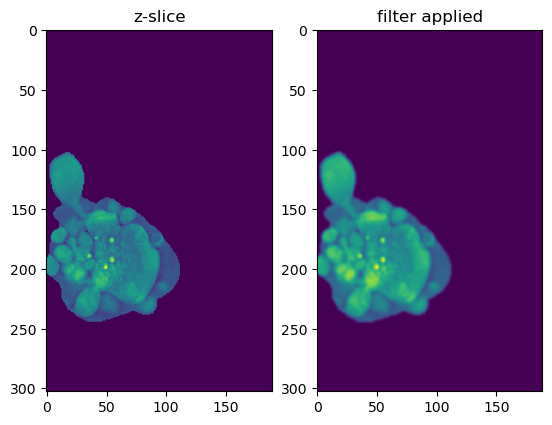

In [55]:
fig, axes = plt.subplots(1,2)
axes[0].imshow(box[30])
axes[0].set_title('z-slice')
axes[1].imshow(filters.gaussian(box[30]))
axes[1].set_title('filter applied')

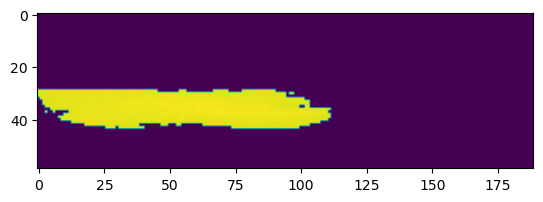

In [76]:
v1 = np.max(box, axis=1)
thr = filters.threshold_multiotsu(v1, 4)
v1[v1<thr[1]]=0
v2 = np.max(v1, axis=1)
height = len(np.where(v2!=0)[0])
plt.imshow(v1)

In [72]:
np.where(v2==0)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 44, 45, 46, 47, 48,
        49, 50, 51, 52, 53, 54, 55, 56, 57, 58], dtype=int64),)

In [46]:
from skimage import morphology

In [51]:
thr = filters.threshold_multiotsu(box, 4)
box[box<thr[1]] = 0
box_mask = morphology.remove_small_objects(box.astype(bool), min_size=300)
viewer.add_image(box_mask)

<Image layer 'box_mask' at 0x2de868c1f10>

In [52]:
box[box_mask==0] = 1.3

In [53]:
time = '01.0'
box_for_labeling = box.copy()
box_for_labeling[box < 1.327] = 0
        
labels = measure.label(box_for_labeling)
properties = ['area', 'area_convex','axis_major_length', 'euler_number', 'extent',
                            'solidity', 'inertia_tensor_eigvals', 'centroid'] 
cell_props = measure.regionprops_table(labels, properties=properties)
cell_props = pd.DataFrame(cell_props)
cell_props = cell_props[cell_props['area'] >= 100]
cell_props = cell_props.replace([-np.inf, np.inf], 0)
        
box_props = pd.DataFrame()
    
# find mean_RI
box_props['mean_RI_above_1.327'] = [np.mean(box_for_labeling[labels!=0])]
    
# find height 
v1 = np.max(box, axis=1)
thr = filters.threshold_multiotsu(v1, 4)
v1[v1<thr[0]] = 0
v2 = np.max(v1, axis=1)
height = len(np.where(v2!=0)[0])
box_props['maximum_height'] = [height]
    
    
    
for cell_prop in list(cell_props.columns):
    if cell_prop=='area':
        box_props['volume_sum'] = [np.sum(cell_props[cell_prop])]
        box_props['volume_mean'] = [np.mean(cell_props[cell_prop])]
        box_props['volume_std'] = [np.std(cell_props[cell_prop])]
    elif cell_prop=='area_convex':
        box_props['volume_convex_sum'] = [np.sum(cell_props[cell_prop])]
        box_props['volume_convex_mean'] = [np.mean(cell_props[cell_prop])]
        box_props['volume_convex_std'] = [np.std(cell_props[cell_prop])]
    else:
        box_props[cell_prop+'_sum'] = [np.sum(cell_props[cell_prop])]
        box_props[cell_prop+'_mean'] = [np.mean(cell_props[cell_prop])]
        box_props[cell_prop+'_std'] = [np.std(cell_props[cell_prop])]

for prop in list(box_props.columns):
    box_props = box_props.rename(columns={prop: time + 'h_' + prop})
            
box_props = box_props.reset_index(drop=True)

In [14]:
viewer.add_image(labels)

<Image layer 'labels [1]' at 0x2ded8237bb0>

In [54]:
box_props

,01.0h_mean_RI_above_1.327,01.0h_maximum_height,01.0h_volume_sum,01.0h_volume_mean,01.0h_volume_std,01.0h_volume_convex_sum,01.0h_volume_convex_mean,01.0h_volume_convex_std,01.0h_axis_major_length_sum,01.0h_axis_major_length_mean,...,01.0h_inertia_tensor_eigvals-2_std,01.0h_centroid-0_sum,01.0h_centroid-0_mean,01.0h_centroid-0_std,01.0h_centroid-1_sum,01.0h_centroid-1_mean,01.0h_centroid-1_std,01.0h_centroid-2_sum,01.0h_centroid-2_mean,01.0h_centroid-2_std
0,1.333528,40,892696.0,446348.0,445601.0,1796532.0,898266.0,894017.0,368.064153,184.032077,...,1075.253572,60.729203,30.364601,0.619334,590.014937,295.007468,76.860001,196.431796,98.215898,37.320316


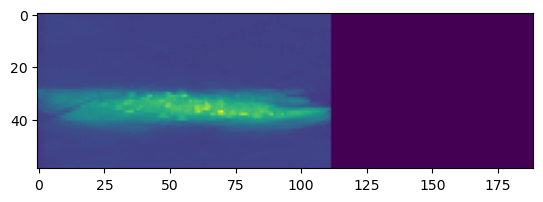

In [64]:
import matplotlib.pyplot as plt

plt.imshow(np.max(box, axis=1))

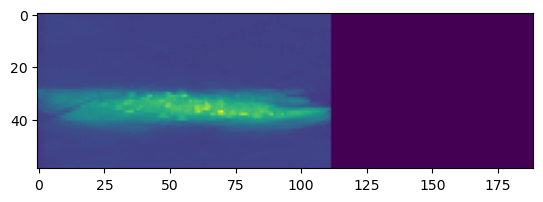

In [65]:
v1 = np.max(box, axis=1)
plt.imshow(v1)

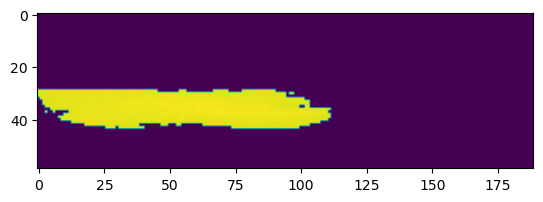

In [67]:
v1 = np.max(box, axis=1)
thr = filters.threshold_multiotsu(v1, 4)
v1[v1<thr[1]] = 0
v2 = np.max(v1, axis=1)
height = len(np.where(v2!=0)[0])
plt.imshow(v1)

In [68]:
height

15

In [35]:
# Thresholding
thr = filters.threshold_multiotsu(box, 4)
box_for_labeling = box.copy()
box_for_labeling[box<thr[1]] = 0

# Gaussiuan
box_for_labeling = filters.gaussian(box_for_labeling)

In [36]:
# Labeling
properties = ['label', 'area', 'area_convex','axis_major_length', 'euler_number', 'extent',
                            'inertia_tensor_eigvals', 'solidity'] 

labels = measure.label(box_for_labeling)
props = measure.regionprops_table(labels, properties=properties)
props = pd.DataFrame(props)
props = props[props['area']>=100]

# find mean RI
cell_props['mean_RI'] = np.mean(box[box!=0])
cell_props

,label,area,area_convex,axis_major_length,euler_number,extent,inertia_tensor_eigvals-0,inertia_tensor_eigvals-1,inertia_tensor_eigvals-2,solidity,mean_RI
0,1,354241.0,533670.0,361.302269,1,0.209862,7113.91078,6545.607426,605.585255,0.663783,1.334008


In [40]:
props = pd.DataFrame(measure.regionprops_table(labels, properties=properties))
props['mean_RI'] = np.mean(box[labels!=0])

In [46]:
np.mean(box[labels!=0])

1.3414646

In [42]:
viewer.add_image(labels)

<Image layer 'labels' at 0x1e987b1d460>

In [41]:
props.replace([-np.inf, np.inf], 0)

,label,area,area_convex,axis_major_length,euler_number,extent,inertia_tensor_eigvals-0,inertia_tensor_eigvals-1,inertia_tensor_eigvals-2,solidity
0,1,274237.0,393769.0,390.032745,4,0.163017,8044.193011,7618.441266,450.080067,0.696441
1,2,20055.0,27531.0,89.077192,0,0.310872,483.042580,404.860676,94.428648,0.728452
2,3,5696.0,10805.0,82.171407,1,0.209289,389.342836,339.194656,53.323488,0.527163
3,4,6.0,0.0,4.472136,1,0.750000,1.166667,1.000000,0.166667,0.000000
4,5,1.0,0.0,0.000000,1,1.000000,0.000000,0.000000,0.000000,0.000000
5,6,1.0,0.0,0.000000,1,1.000000,0.000000,0.000000,0.000000,0.000000
6,7,116.0,157.0,13.222207,1,0.405594,12.470604,8.964998,3.952924,0.738854
7,8,4.0,0.0,2.236068,1,1.000000,0.500000,0.250000,0.250000,0.000000
8,9,6.0,0.0,4.472136,1,0.750000,1.166667,1.000000,0.166667,0.000000
9,10,55.0,72.0,14.706183,1,0.423077,12.084585,10.922724,1.380128,0.763889


In [32]:
viewer.add_image(box)

<Image layer 'box' at 0x1e987908850>

In [26]:
box[labels==0]=1.3

In [41]:
cell_props_list[0] = cell_props_list[0].reset_index(drop=True)
cell_props_list[1] = cell_props_list[1].reset_index(drop=True)

In [42]:
df = pd.DataFrame()
df = pd.concat(cell_props_list, axis=1, ignore_index=True)
df

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,5,854596.0,2986046.0,486.956102,-346,0.153452,14419.513539,11911.148045,2618.037081,0.286197,...,354241.0,533670.0,361.302269,1,0.209862,7113.91078,6545.607426,605.585255,0.663783,1.340485
